In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import scikeras
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


file_path = 'dataset/Wednesday-workingHours.pcap_ISCX.csv'
data = pd.read_csv(file_path)

df = data.copy()
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df.columns = df.columns.str.strip().str.replace('[ /]', '_', regex=True)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)

X = df.drop('Label', axis=1)
y = df['Label']
y_binary = np.where(y == 'BENIGN', 0, 1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_binary, test_size=0.15, random_state=42, stratify=y_binary
)

print("## 모델 불러오기")

import joblib
import os

rf_full_path = 'models/rf_model_full.pkl'
rf_top6_path = 'models/rf_model_top6.pkl'
lstm_path = 'models/lstm_model.pkl'

rf_full_model = joblib.load(rf_full_path)
rf_top6_model = joblib.load(rf_top6_path)
lstm_model = joblib.load(lstm_path)


features_path = open('models/top6_features.txt', 'r')
top6_features = [line.strip() for line in features_path.readlines()]
features_path.close()
print("## Top 6 Features:", top6_features)

X_train_top6 = X_train[top6_features]
X_test_top6 = X_test[top6_features]

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_lstm = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_lstm = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])





## 모델 불러오기
## Top 6 Features: ['Avg_Bwd_Segment_Size', 'Max_Packet_Length', 'Bwd_Packet_Length_Max', 'Packet_Length_Std', 'Average_Packet_Size', 'Destination_Port']


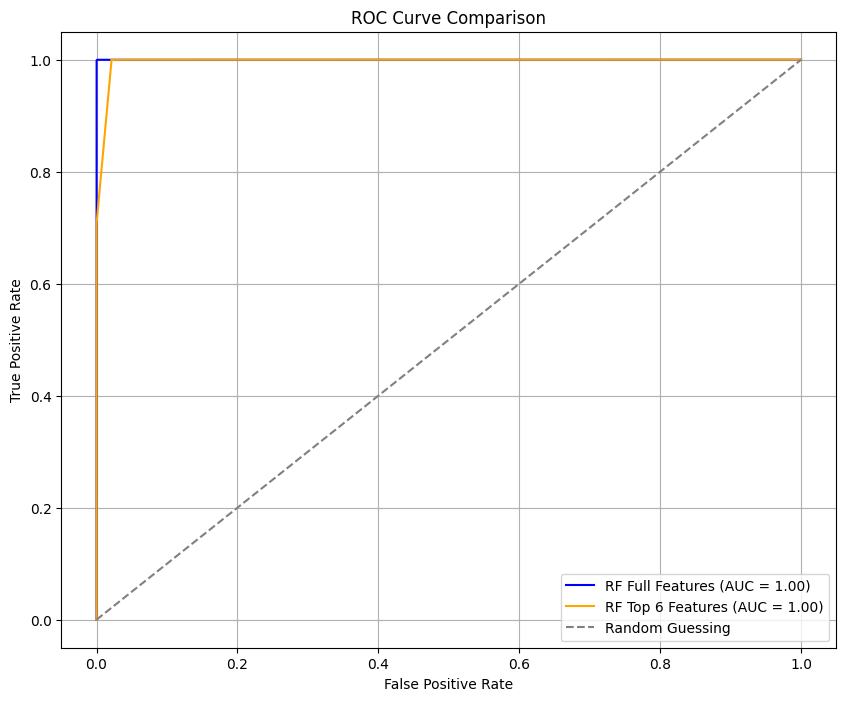

In [ ]:
## ROC 곡선 시각화
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr_rf_full, tpr_rf_full, _ = roc_curve(y_test, rf_full_model.predict_proba(X_test)[:, 1])
fpr_rf_top6, tpr_rf_top6, _ = roc_curve(y_test, rf_top6_model.predict_proba(X_test_top6)[:, 1])
roc_auc_rf_full = auc(fpr_rf_full, tpr_rf_full)
roc_auc_rf_top6 = auc(fpr_rf_top6, tpr_rf_top6)
fpr_lstm, tpr_lstm, _ = roc_curve(y_test, lstm_model.predict_proba(X_test_lstm)[:, 1])
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)

plt.figure(figsize=(10, 8))
plt.plot(fpr_rf_full, tpr_rf_full, color='blue', label=f'RF Full Features (AUC = {roc_auc_rf_full:.4f})')
plt.plot(fpr_rf_top6, tpr_rf_top6, color='orange', label=f'RF Top 6 Features (AUC = {roc_auc_rf_top6:.4f})')
plt.plot(fpr_lstm, tpr_lstm, color='red', label=f'LSTM (AUC = {roc_auc_lstm:.4f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid()
plt.savefig('roc_curve_comparison.png')

plt.show()